<a href="https://colab.research.google.com/github/Beagan19/Classification-Metabolic-Syndrome-Prediction/blob/main/Classification_Metabolic_Syndrome_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Metabolic Syndrome Predictions
Brooke Eagan

## Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatplotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

from scipy import stats

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

## Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


## Classification Metrics
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, 
                             PrecisionRecallDisplay, RocCurveDisplay, 
                             f1_score, accuracy_score, classification_report)

## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [3]:
## Create a function to display the classification metrics of a model
def classification_metrics(model, X_test, y_test, label='Test Data', 
                             figsize=(15,5), normalize='true',
                             cmap='Greens'): 
                             
    fig, axes = plt.subplots(1,2, figsize=figsize)

    ## Get the predictions
    y_pred = model.predict(X_test)
     
   ## Print classification report for the test data (and make it pretty!)
    print('---'*20)
    print(f"[i] CLASSIFICATION REPORT FOR: {label}")
    print('---'*20)

    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, 
                normalize=normalize, cmap=cmap,              
                ax=axes[0])    
    
    RocCurveDisplay.from_estimator(model, X_test, y_test,
                                   ax=axes[1])
    plt.show()

In [4]:
# Create a function to display supplemental statistics 
def outlier_statistics(df, column_name):
    
    # Determine Outliers - Only if this is a numeric column
    if (df[column_name].dtype == 'int64') | (df[column_name].dtype == 'float64'):
        # Create outlier filters
        q1 = df[column_name].quantile(0.25) # 25th percentile
        q3 = df[column_name].quantile(0.75) # 75th percentile
        iqr = q3 - q1 # Interquartile range
        low_limit = q1 - (1.5 * iqr) # low limit
        high_limit = q3 + (1.5 * iqr) # high limit
        # Create outlier dataframes
        low_df = df[(df[column_name] < low_limit)]
        high_df = df[(df[column_name] > high_limit)]
        # Calculate the outlier counts and percentages
        low_oulier_count = low_df.shape[0]
        low_outlier_percentge = round(((low_oulier_count)/(df.shape[0])*100),1)
        high_oulier_count = high_df.shape[0]
        high_outlier_percentge = round(((high_oulier_count)/(df.shape[0])*100),1)
        # Display the outlier counts.
        print(f'Outliers: {low_oulier_count} ({low_outlier_percentge})% low, {high_oulier_count} ({high_outlier_percentge})% high')

In [5]:
metabolic_df = pd.read_csv('/content/drive/MyDrive/Project 2- ML/Metabolic Syndrome.csv')

In [6]:
metabolic_df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [7]:
metabolic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


In [8]:
# Display the number of rows and columns for the dataframe
metabolic_df.shape
print(f'There are {metabolic_df.shape[0]} rows, and {metabolic_df.shape[1]} columns.')
print(f'The rows represent {metabolic_df.shape[0]} observations, and the columns represent {metabolic_df.shape[1]-1} features and 1 target variable.')

There are 2401 rows, and 15 columns.
The rows represent 2401 observations, and the columns represent 14 features and 1 target variable.


In [9]:
# Display the descriptive statistics for the numeric columns
metabolic_df.describe(include="number")

,seqn,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,67030.674302,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,2823.565114,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,62161.000000,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,64591.000000,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,67059.000000,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,69495.000000,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,71915.000000,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


In [10]:
# Display the descriptive statistics for the numeric columns
metabolic_df.describe(include="object")

,Sex,Marital,Race,MetabolicSyndrome
count,2401,2193,2401,2401
unique,2,5,6,2
top,Female,Married,White,No MetSyn
freq,1211,1192,933,1579


## Data Cleaning

### Drop Unneccessay Columns

In [11]:
# Drop
metabolic_df = metabolic_df.drop(columns=['seqn'])

- This column will not help with predicting values.

### Duplicate rows

In [12]:
# Check duplicate rows
metabolic_df.duplicated().sum()

0

- There are no duplicate rows.

In [13]:
# check for number of unique values in each column
metabolic_df.nunique()

Age                    61
Sex                     2
Marital                 5
Income                 14
Race                    6
WaistCirc             635
BMI                   322
Albuminuria             3
UrAlbCr              1383
UricAcid               88
BloodGlucose          187
HDL                    93
Triglycerides         345
MetabolicSyndrome       2
dtype: int64

In [14]:
# Display column names
metabolic_df.columns

Index(['Age', 'Sex', 'Marital', 'Income', 'Race', 'WaistCirc', 'BMI',
       'Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL',
       'Triglycerides', 'MetabolicSyndrome'],
      dtype='object')

- No errors noted.

### Inspect Values for Errors

In [15]:
# Display all values in column
pd.set_option('display.max_rows', None)

In [16]:
# check inappropriate Na_to_K data points
metabolic_df['Age'].value_counts()

80    124
60     54
22     53
63     53
31     52
39     49
70     49
21     48
30     48
29     47
42     47
50     46
36     46
20     46
43     46
24     45
54     45
56     44
34     44
40     44
62     44
51     43
65     43
37     42
52     42
45     42
23     41
38     41
41     41
58     40
27     40
46     40
64     40
33     39
47     38
35     37
44     37
48     36
32     36
55     36
25     35
69     35
49     35
59     33
68     32
28     32
26     31
61     31
53     31
57     29
78     26
66     26
67     26
71     25
74     25
75     23
77     21
73     20
76     20
72     19
79     18
Name: Age, dtype: int64

In [17]:
# check inappropriate Na_to_K data points
metabolic_df['Sex'].value_counts()

Female    1211
Male      1190
Name: Sex, dtype: int64

In [18]:
# check inappropriate Na_to_K data points
metabolic_df['Marital'].value_counts()

Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: Marital, dtype: int64

In [19]:
# check inappropriate Na_to_K data points
metabolic_df['Income'].value_counts()

9000.0    337
2500.0    257
3500.0    228
1000.0    210
2000.0    207
1600.0    190
8200.0    178
6200.0    138
4500.0    136
800.0     123
5400.0    103
300.0      93
1700.0     54
1500.0     30
Name: Income, dtype: int64

In [20]:
# check inappropriate Na_to_K data points
metabolic_df['Race'].value_counts()

White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: Race, dtype: int64

In [21]:
# check inappropriate Na_to_K data points
metabolic_df['WaistCirc'].value_counts()

97.0     23
100.0    17
103.0    14
99.0     13
89.0     12
90.0     12
95.0     12
83.0     12
101.2    11
91.6     11
104.0    11
80.5     10
97.1     10
93.3     10
96.5     10
87.2     10
91.0     10
78.0     10
81.0     10
85.0      9
100.8     9
109.0     9
106.6     9
94.2      9
74.0      9
95.4      9
96.2      9
87.0      9
100.5     9
77.0      9
80.0      9
102.4     9
75.5      8
98.5      8
98.6      8
91.2      8
82.8      8
116.0     8
102.5     8
93.5      8
99.9      8
82.0      8
101.0     8
106.0     8
94.3      8
96.0      8
110.0     8
102.3     8
87.3      8
80.3      8
111.5     8
95.8      7
92.6      7
90.2      7
108.0     7
95.5      7
86.2      7
90.5      7
106.2     7
103.2     7
110.8     7
92.1      7
101.8     7
101.4     7
102.1     7
92.0      7
93.0      7
88.2      7
99.8      7
105.0     7
115.5     7
86.4      7
107.2     7
100.4     7
105.1     7
80.1      7
112.0     7
107.8     7
98.2      7
105.4     7
85.2      7
97.2      7
90.1      7
115.

In [22]:
# check inappropriate Na_to_K data points
metabolic_df['BMI'].value_counts()

23.3    24
25.8    24
24.7    23
24.9    21
27.7    21
22.0    20
30.5    20
26.4    19
27.3    19
31.9    19
28.4    19
27.4    19
27.6    19
23.2    19
28.9    19
26.7    18
28.1    18
29.3    18
23.5    18
22.3    18
24.5    18
24.3    18
24.0    17
23.4    17
26.3    17
31.8    17
28.2    17
25.3    17
28.0    17
25.2    17
26.2    17
28.3    16
27.8    16
28.6    16
26.5    16
29.7    16
27.1    16
24.8    16
22.9    16
29.4    16
32.5    16
30.1    16
20.6    16
22.8    16
26.6    16
25.9    16
24.6    16
25.5    16
25.6    15
30.2    15
22.5    15
29.8    15
27.0    15
28.7    15
31.1    15
23.6    15
27.5    15
26.9    14
29.6    14
30.9    14
26.8    14
25.0    14
23.7    14
23.8    14
33.3    14
27.2    14
31.2    13
26.1    13
24.4    13
31.3    13
28.8    13
30.6    13
20.8    13
27.9    13
23.0    13
22.6    13
21.9    13
22.4    12
29.2    12
22.7    12
26.0    12
24.1    12
25.1    12
33.1    12
32.0    12
23.9    12
21.5    12
30.3    12
25.4    11
30.8    11
35.0    11

In [23]:
# check inappropriate Na_to_K data points
metabolic_df['Albuminuria'].value_counts()

0    2089
1     254
2      58
Name: Albuminuria, dtype: int64

In [24]:
# check inappropriate Na_to_K data points
metabolic_df['UrAlbCr'].value_counts()

5.00       18
10.00      12
6.67       10
5.38       10
5.56        9
3.73        8
3.33        8
3.42        7
5.95        7
6.27        7
4.55        7
4.15        7
4.29        7
2.96        7
4.58        7
3.92        7
4.44        7
8.57        6
3.80        6
4.36        6
4.05        6
5.63        6
5.42        6
8.75        6
20.00       6
4.00        6
3.44        6
4.18        6
6.40        6
7.14        6
2.50        6
5.89        6
7.50        6
2.83        6
5.71        6
8.62        5
3.67        5
4.62        5
5.12        5
4.68        5
5.26        5
7.88        5
4.53        5
6.22        5
4.40        5
3.49        5
3.16        5
3.23        5
5.81        5
6.79        5
5.25        5
4.14        5
4.31        5
4.72        5
3.97        5
5.06        5
4.81        5
5.15        5
5.07        5
6.82        4
4.88        4
3.81        4
5.75        4
5.47        4
4.02        4
4.77        4
8.06        4
7.78        4
6.17        4
3.93        4
3.19        4
7.64  

In [25]:
# check inappropriate Na_to_K data points
metabolic_df['UricAcid'].value_counts()

5.2     77
5.8     75
4.6     71
5.4     69
5.0     69
4.8     67
5.5     66
5.6     66
5.7     65
5.1     64
4.4     62
5.3     62
4.9     61
4.5     59
6.1     58
6.2     55
5.9     54
4.7     53
6.7     53
3.8     52
6.0     52
4.2     52
6.3     51
4.3     50
6.4     49
4.0     46
3.4     44
6.6     43
6.8     40
6.5     39
3.9     39
4.1     38
6.9     35
7.0     33
7.2     32
7.1     29
3.6     28
3.5     27
7.3     25
3.3     24
3.2     24
3.7     23
7.8     22
7.4     21
7.5     20
7.7     17
3.1     16
3.0     15
8.0     14
2.8     14
7.6     13
8.1     13
7.9     13
8.5     12
2.9     10
8.4     10
2.7     10
8.3     10
8.6      9
8.2      8
8.8      7
2.5      6
9.1      6
8.7      6
8.9      5
9.9      5
9.3      5
9.4      5
10.0     3
9.5      3
9.2      3
2.6      2
2.1      2
2.4      1
9.0      1
2.3      1
10.2     1
11.0     1
10.5     1
1.8      1
10.9     1
9.8      1
11.2     1
1.9      1
9.6      1
11.3     1
9.7      1
2.2      1
Name: UricAcid, dtype: int64

In [26]:
# check inappropriate Na_to_K data points
metabolic_df['BloodGlucose'].value_counts()

97     90
98     87
96     87
94     86
99     85
100    78
93     77
102    73
103    72
91     72
92     70
95     70
90     68
101    66
105    64
107    64
88     61
89     53
108    51
87     44
104    44
86     43
111    43
85     43
106    38
109    36
110    35
84     31
83     29
112    29
115    24
116    24
113    22
114    21
118    19
81     17
80     16
82     15
117    15
121    13
124    12
126    12
128    11
123    11
130    11
120    11
122    10
125    10
77      9
129     9
79      9
133     9
75      9
144     9
119     8
127     8
135     7
138     7
78      7
132     6
142     6
147     6
141     6
134     5
131     5
162     5
160     4
223     4
155     4
171     4
148     4
180     4
172     4
136     4
154     3
137     3
156     3
73      3
70      3
71      3
204     3
169     3
181     3
143     3
176     3
72      3
157     3
140     3
74      3
237     3
139     3
145     3
219     3
153     3
163     2
201     2
173     2
193     2
182     2
166     2


In [27]:
# check inappropriate Na_to_K data points
metabolic_df['HDL'].value_counts()

48     87
53     84
44     84
52     79
51     76
42     73
46     73
43     73
40     70
50     64
47     64
54     62
49     61
39     61
45     57
41     56
62     55
58     52
56     52
59     52
57     51
55     51
65     50
61     48
38     47
36     42
60     40
63     40
34     37
35     36
37     35
64     32
69     31
66     31
71     27
33     27
68     27
72     23
67     21
31     21
70     19
32     18
75     18
78     17
30     17
83     16
80     16
77     16
74     15
76     14
73     13
29     10
84      9
82      9
90      8
79      8
28      8
88      7
85      7
81      7
27      7
86      7
97      7
91      7
26      6
95      6
89      6
87      5
94      5
21      5
92      4
98      3
25      3
108     3
104     3
93      2
22      2
14      1
106     1
99      1
121     1
125     1
24      1
96      1
101     1
107     1
100     1
156     1
119     1
138     1
23      1
150     1
114     1
Name: HDL, dtype: int64

In [28]:
# check inappropriate Na_to_K data points
metabolic_df['Triglycerides'].value_counts()

75      34
91      28
78      28
76      27
89      27
64      26
62      26
92      25
86      25
85      24
98      24
65      24
67      24
87      24
101     23
105     23
84      23
94      23
93      22
55      22
95      22
58      21
80      21
119     20
70      20
81      20
71      20
90      20
60      19
72      19
77      19
61      19
109     19
117     18
83      18
125     18
114     18
54      18
124     18
73      18
68      18
59      18
66      17
74      17
102     17
106     17
107     17
111     16
99      16
112     16
97      16
79      16
63      16
69      16
52      16
115     16
120     15
113     15
53      15
82      15
138     15
88      15
44      15
134     14
103     14
127     14
46      14
144     14
118     14
56      14
108     14
167     14
96      13
45      13
151     13
42      13
148     13
104     13
128     12
145     12
50      12
146     12
130     12
123     12
122     12
126     12
139     12
147     12
174     12
129     12
163     12

In [29]:
# check inappropriate Na_to_K data points
metabolic_df['MetabolicSyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [30]:
# Display the descriptive statistics for the numeric columns
metabolic_df.describe(include="number")

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
count,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364
std,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477
min,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000
25%,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000
50%,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000
75%,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000
max,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000


- All column values appear to have appropriate values.

### Missing Values

In [31]:
# Check for number of missing values in each column
metabolic_df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

- Marital, Income, WaistCirc, and BMI have missing values. These will be imputed after splitting the data using simple imputer strategy constant = unknown for missing categorical values and simple imputer strategy median for missing numeric values to minimize bias in dataset.

## Create Copies of dataset for EDA and ML

In [32]:
## Make a copy of the dataset for exploratory visualization
eda_df = metabolic_df.copy()

In [33]:
## Make a copy of the dataset for machine learning
ml_df = metabolic_df.copy()

## Exploratory Visualization

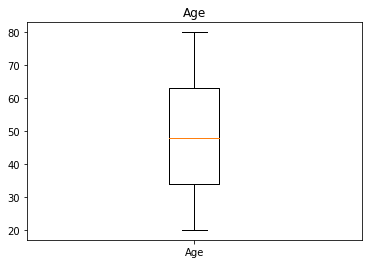

In [34]:
# boxplot for item weight
plt.boxplot(eda_df['Age'], labels= ['Age'])
plt.title('Age');

- This is a normal distribution. There are no outliers.

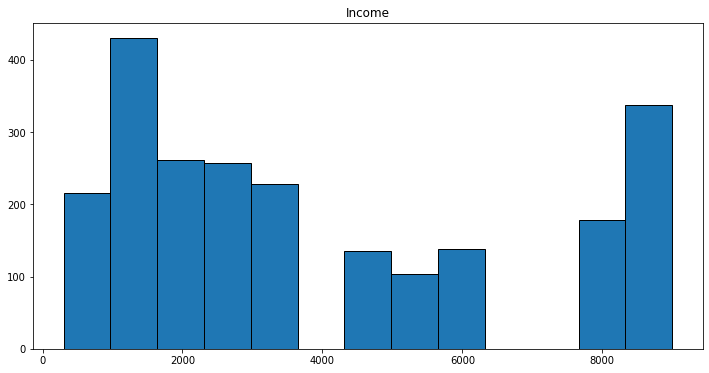

In [35]:
# histogram for Sodium to Potassium ratio in blood
plt.figure(figsize= (12,6))
eda_df['Income'].hist(bins = 'auto', edgecolor = 'black', grid=False)
plt.title('Income');

In [36]:
outlier_statistics(eda_df, 'Income')

Outliers: 0 (0.0)% low, 0 (0.0)% high


- There are no outliers noted. Most values are between 1,000 and 1,500.

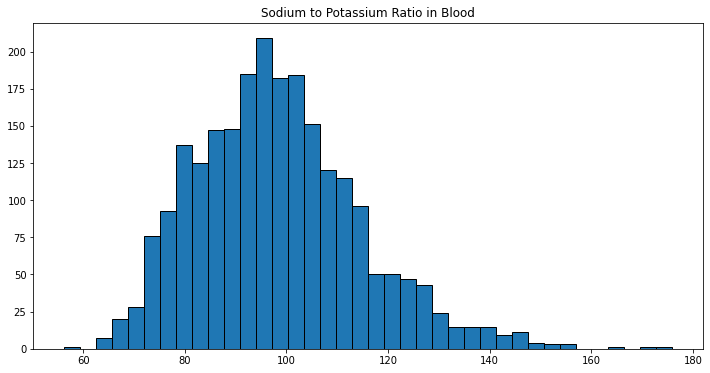

In [37]:
# histogram for Sodium to Potassium ratio in blood
plt.figure(figsize= (12,6))
eda_df['WaistCirc'].hist(bins = 'auto', edgecolor = 'black', grid=False)
plt.title('Sodium to Potassium Ratio in Blood');

In [53]:
outlier_statistics(eda_df, 'WaistCirc')

Outliers: 0 (0.0)% low, 44 (1.8)% high


- There are 44 outliers on the high side. Most values are between 93 and 96.

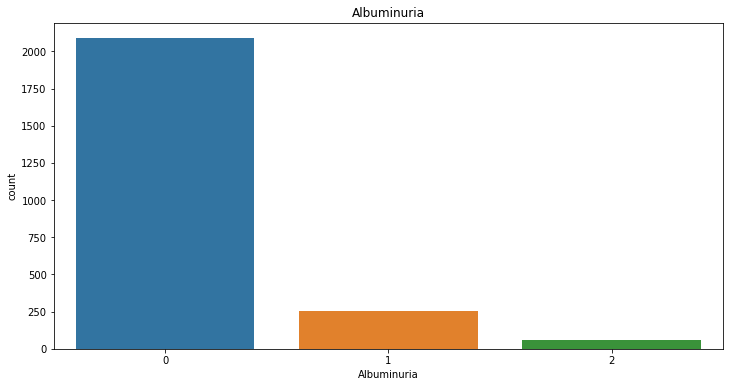

In [38]:
# count plot of albuminuria
plt.figure(figsize= (12,6))
sns.countplot(data = eda_df, x = 'Albuminuria', order=eda_df['Albuminuria'].value_counts().index)
plt.title('Albuminuria');

In [55]:
outlier_statistics(eda_df, 'Albuminuria')

Outliers: 0 (0.0)% low, 312 (13.0)% high


- There are 312 outliers on the high side. There are significanly more '0' values than '1' or '2' values.

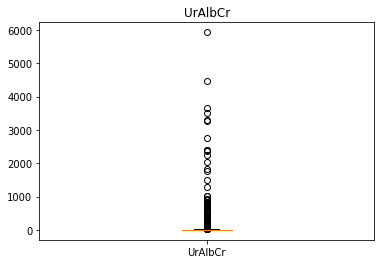

In [39]:
# histogram for UrAlbCr
plt.boxplot(eda_df['UrAlbCr'], labels= ['UrAlbCr'])
plt.title('UrAlbCr');

In [40]:
outlier_statistics(eda_df, 'UrAlbCr')

Outliers: 0 (0.0)% low, 332 (13.8)% high


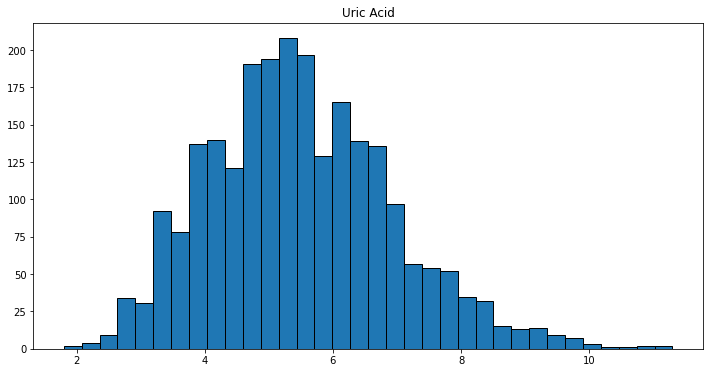

In [41]:
# histogram for uric acid
plt.figure(figsize= (12,6))
eda_df['UricAcid'].hist(bins = 'auto', edgecolor = 'black', grid=False)
plt.title('Uric Acid');

In [42]:
outlier_statistics(eda_df, 'UricAcid')

Outliers: 0 (0.0)% low, 30 (1.2)% high


-  There are 30 outliers on the high side. The most values are between 5.25 and 5.50.

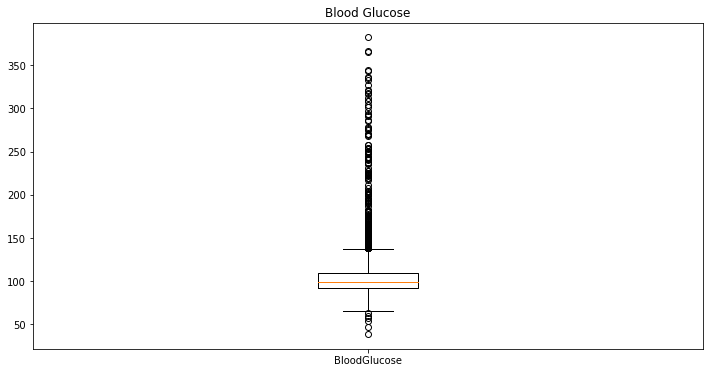

In [43]:
# boxplot for item weight
plt.figure(figsize= (12,6))
plt.boxplot(eda_df['BloodGlucose'], labels= ['BloodGlucose'])
plt.title('Blood Glucose');

In [44]:
outlier_statistics(eda_df, 'BloodGlucose')

Outliers: 6 (0.2)% low, 214 (8.9)% high


- There are 6 outliers on the low side and 214 outliers on the high side.

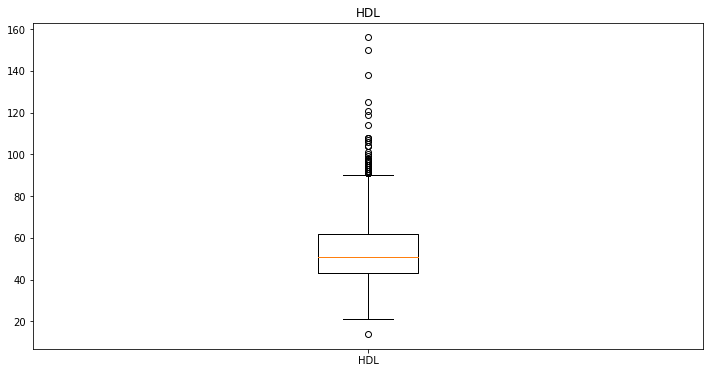

In [45]:
# boxplot for item weight
plt.figure(figsize= (12,6))
plt.boxplot(eda_df['HDL'], labels= ['HDL'])
plt.title('HDL');

In [46]:
outlier_statistics(eda_df, 'HDL')

Outliers: 1 (0.0)% low, 53 (2.2)% high


- There is 1 outlier on the low side 53 outliers on the high side.

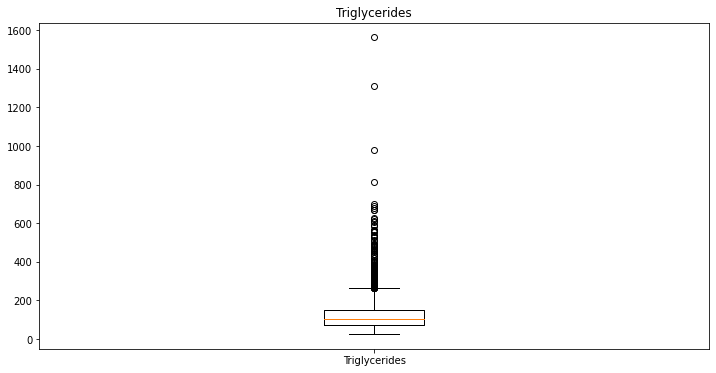

In [47]:
# boxplot for item weight
plt.figure(figsize= (12,6))
plt.boxplot(eda_df['Triglycerides'], labels= ['Triglycerides'])
plt.title('Triglycerides');

In [48]:
outlier_statistics(eda_df, 'Triglycerides')

Outliers: 0 (0.0)% low, 161 (6.7)% high


- There are 161 outliers on the high side.

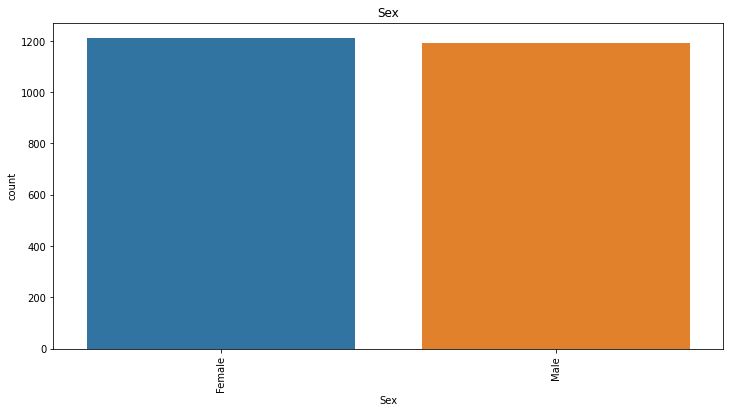

In [49]:
# count plot of type of drug
plt.figure(figsize= (12,6))
sns.countplot(data = eda_df, x = 'Sex', order=eda_df['Sex'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Sex');

- There are sllightly more females than males.

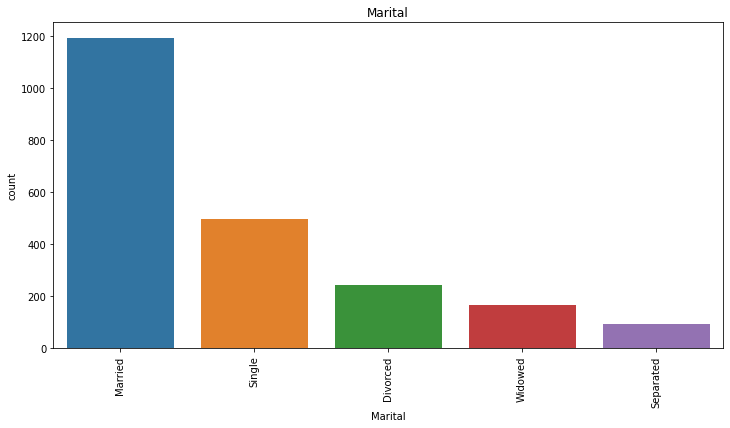

In [50]:
# count plot of type of drug
plt.figure(figsize= (12,6))
sns.countplot(data = eda_df, x = 'Marital', order=eda_df['Marital'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Marital');

- Most are married.

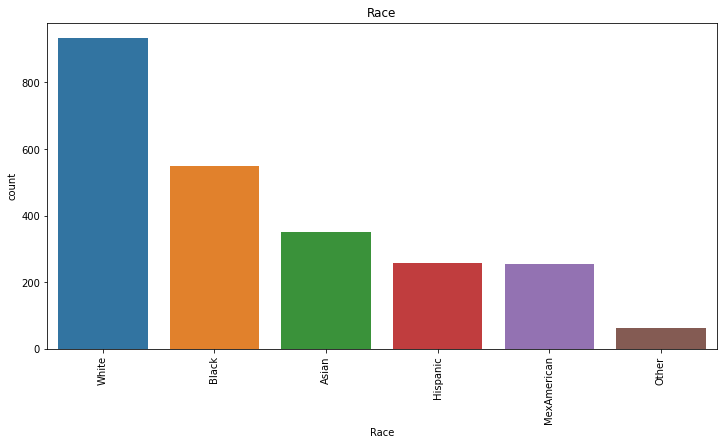

In [51]:
# count plot of type of drug
plt.figure(figsize= (12,6))
sns.countplot(data = eda_df, x = 'Race', order=eda_df['Race'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Race');

- Most are white.

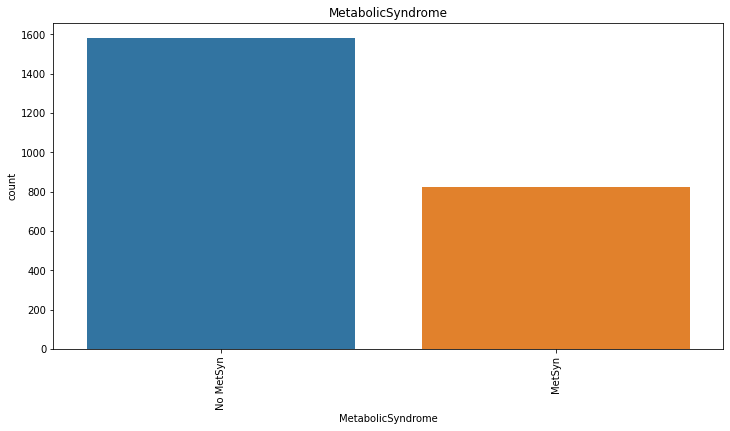

In [52]:
# count plot of type of drug
plt.figure(figsize= (12,6))
sns.countplot(data = eda_df, x = 'MetabolicSyndrome', order=eda_df['MetabolicSyndrome'].value_counts().index)
plt.xticks(rotation=90)
plt.title('MetabolicSyndrome');

- Most do not have metabolic syndrome.